In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2


def load_and_preprocess(folder_path):
  # Iterate through all the images in the folder
  for filename in os.listdir(folder_path):
      if filename.endswith(".png"):
          # Load the X-ray image
          image = Image.open(os.path.join(folder_path, filename))

          # Noise Reduction: Gaussian Blur
          blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

          # Edge Detection: Canny Edge Detector
          edges = cv2.Canny(blurred_image, 50, 150)

          # Find contours
          contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          # Draw contours on a blank image
          contour_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
          cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

          roi = contour_img[14:255 , 20:282]

          return roi

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_path = "/content/drive/MyDrive/Train_withoutMask"
test_path = "/content/drive/MyDrive/Test_withoutMask"

batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=load_and_preprocess(train_path)
)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=load_and_preprocess(test_path))

# Train/validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',

)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping

# Load pre-trained MobileNetV2 model
mobile_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in mobile_model.layers:
    layer.trainable = False

def build_model(hp):
    model = Sequential([
        mobile_model,
        Flatten(),
        Dense(units=hp.Int('units', min_value=256, max_value=1024, step=64), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2, # Adjust this as needed
    directory='tuner_results',
    project_name='xception_tuning'
)

tuner.search(train_generator, validation_data=validation_generator, epochs=5,batch_size=20)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)

es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3)

# Train the best model
H = best_model.fit(train_generator,
               validation_data=validation_generator,
               epochs=10,
               callbacks=[es]
               )


Trial 2 Complete [00h 47m 55s]
val_accuracy: 0.9449999928474426

Best val_accuracy So Far: 0.9524999856948853
Total elapsed time: 01h 40m 45s
Epoch 1/10
50/50 [==============================] - 565s 11s/step - loss: 3.2985 - accuracy: 0.9319 - val_loss: 1.9113 - val_accuracy: 0.9125
Epoch 2/10
50/50 [==============================] - 565s 11s/step - loss: 0.8275 - accuracy: 0.9450 - val_loss: 0.6241 - val_accuracy: 0.9425
Epoch 3/10
50/50 [==============================] - 561s 11s/step - loss: 0.2019 - accuracy: 0.9619 - val_loss: 0.5018 - val_accuracy: 0.9300
Epoch 4/10
50/50 [==============================] - 562s 11s/step - loss: 0.2653 - accuracy: 0.9513 - val_loss: 0.2788 - val_accuracy: 0.9300
Epoch 4: early stopping


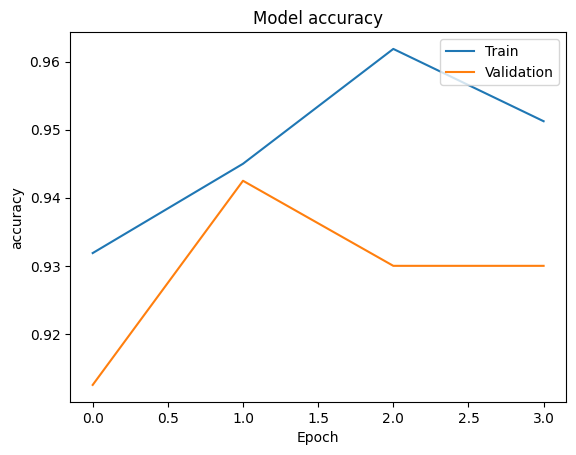

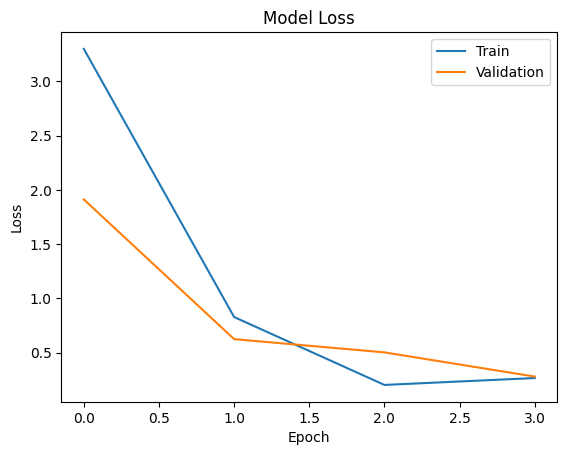

In [ ]:
import matplotlib.pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
drive_path = '/content/drive/My Drive/'
best_model.save(drive_path+'Xception_roi.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_true = test_generator.classes
y_pred = best_model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_binary)
class_report = classification_report(y_true, y_pred_binary)
print("Classification Report:\n", class_report)

7/7 [==============================] - 60s 8s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.58      0.56       100
           1       0.54      0.49      0.51       100

    accuracy                           0.54       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.54      0.54      0.53       200



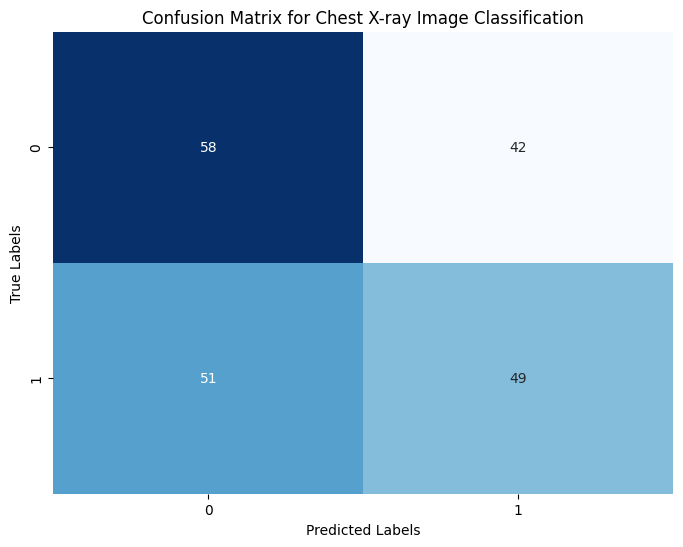

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Chest X-ray Image Classification')
plt.show()

In [ ]:
import pickle
# Extract model weights and architecture
model_weights = best_model.get_weights()
model_config =best_model.get_config()

# Save weights and config as a .pkl file
with open('xception_model.pkl', 'wb') as f:
    pickle.dump([model_weights, model_config], f)

In [ ]:
from tensorflow.keras.preprocessing import image

# Define function to predict on an image
def predict_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed by your model
  img = image.img_to_array(img)
  img = img / 255.0  # Normalize image (assuming model expects normalized input)
  img = np.expand_dims(img, axis=0)  # Add batch dimension
  pred = best_model.predict(img)[0][0]  # Get probability for positive class

  if pred > 0.5:  # Adjust threshold as needed
    return "COVID-19 Positive ({:.2f}%)".format(pred * 100)
  else:
    return "COVID-19 Negative ({:.2f}%)".format((1 - pred) * 100)

# Specify the folder containing test images
test_folder = "/content/drive/MyDrive/Test_withoutMask/Covid/COVID-1002.png"
predict_image(test_folder)

1/1 [==============================] - 1s 1s/step


'COVID-19 Negative (61.61%)'

In [ ]:
from tensorflow.keras.preprocessing import image

# Define function to predict on an image
def predict_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed by your model
  img = image.img_to_array(img)
  img = img / 255.0  # Normalize image (assuming model expects normalized input)
  img = np.expand_dims(img, axis=0)  # Add batch dimension
  pred = best_model.predict(img)[0][0]  # Get probability for positive class

  if pred > 0.5:  # Adjust threshold as needed
    return "COVID-19 Positive ({:.2f}%)".format(pred * 100)
  else:
    return "COVID-19 Negative ({:.2f}%)".format((1 - pred) * 100)

# Specify the folder containing test images
test_folder = "/content/drive/MyDrive/Train_withoutMask/covid_positive/COVID-1.png"
predict_image(test_folder)

1/1 [==============================] - 1s 547ms/step


'COVID-19 Positive (100.00%)'

In [ ]:
from tensorflow.keras.preprocessing import image

# Define function to predict on an image
def predict_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed by your model
  img = image.img_to_array(img)
  img = img / 255.0  # Normalize image (assuming model expects normalized input)
  img = np.expand_dims(img, axis=0)  # Add batch dimension
  pred = best_model.predict(img)[0][0]  # Get probability for positive class

  if pred > 0.5:  # Adjust threshold as needed
    return "COVID-19 Positive ({:.2f}%)".format(pred * 100)
  else:
    return "COVID-19 Negative ({:.2f}%)".format((1 - pred) * 100)

# Specify the folder containing test images
test_folder = "/content/drive/MyDrive/Test_withoutMask/normal/Normal-1004.png"
predict_image(test_folder)

1/1 [==============================] - 0s 356ms/step


'COVID-19 Negative (100.00%)'

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/h5 filesXception_roi.h5")

In [ ]:
import cv2
import numpy as np

def pattern_matching(target_image, template_covid, template_normal):
    # Convert target image to grayscale
    target_gray = cv2.cvtColor(target_image, cv2.IMREAD_GRAYSCALE)

    # Perform template matching for COVID template
    res_covid = cv2.matchTemplate(target_gray, template_covid, cv2.TM_CCOEFF_NORMED)
    min_val_covid, max_val_covid, min_loc_covid, max_loc_covid = cv2.minMaxLoc(res_covid)

    # Perform template matching for normal template
    res_normal = cv2.matchTemplate(target_gray, template_normal, cv2.TM_CCOEFF_NORMED)
    min_val_normal, max_val_normal, min_loc_normal, max_loc_normal = cv2.minMaxLoc(res_normal)

    # Threshold for a good match
    threshold = 0.8

    print("Max value COVID:", max_val_covid)
    print("Max value Normal:", max_val_normal)

    # Check which template has the highest similarity
    if max_val_covid >= threshold or max_val_normal >= threshold:
        if max_val_covid >= max_val_normal:
            top_left = max_loc_covid
            w, h = template_covid.shape[::-1]
            return "COVID", (top_left[0] + w // 2, top_left[1] + h // 2)
        else:
            top_left = max_loc_normal
            w, h = template_normal.shape[::-1]
            return "Normal", (top_left[0] + w // 2, top_left[1] + h // 2)
    else:
        return None, None

# Load the target image (chest X-ray)
target_image = cv2.imread('/content/drive/MyDrive/Test_withoutMask/normal/Normal-1005.png')

# Load the template images (patterns to match)
template_covid = cv2.imread('/content/drive/MyDrive/Test_withoutMask/Covid/COVID-1008.png', cv2.IMREAD_GRAYSCALE)
template_normal = cv2.imread('/content/drive/MyDrive/Test_withoutMask/normal/Normal-1005.png', cv2.IMREAD_GRAYSCALE)

# Perform pattern matching
result, match_location = pattern_matching(target_image, template_covid, template_normal)

if result:
    print("Pattern detected:", result)
    print("Pattern found at location:", match_location)
else:
    print("Pattern not found.")


Max value COVID: 0.3065757155418396
Max value Normal: 0.9999999403953552
Pattern detected: Normal
Pattern found at location: (149, 149)


**SAMPLE FINAL PATTERN MATCHING**

X and Y coordinates: (14, 20)


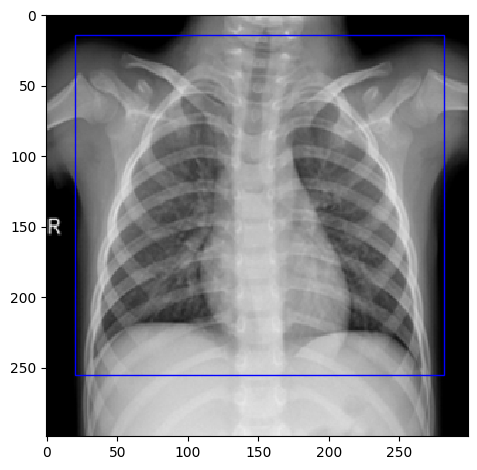

In [ ]:
 from skimage.io import imread, imshow
 from skimage.feature import match_template
 from skimage.feature import peak_local_max
 import matplotlib.pyplot as plt
 import numpy as np
 import cv2

 from skimage.feature import match_template


template_image = cv2.imread('/content/drive/MyDrive/Test_withoutMask/normal/Normal-1005.png', cv2.IMREAD_GRAYSCALE)
template = template_image[14:255 , 20:282]
imshow(template);

result = match_template(template_image, template)
imshow(result, cmap='viridis');

x, y = np.unravel_index(np.argmax(result), result.shape)
print("X and Y coordinates:",(x, y))

imshow(template_image)
template_width, template_height = template.shape
rect = plt.Rectangle((y, x), template_height, template_width,
                         color='b', fc='none')
plt.gca().add_patch(rect);